# PSI Prediction in Singapore

## 0- Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def edge_from_center(bin_centers):
    bin_edges = (bin_centers[:-1] + bin_centers[1:]) / 2
    bin_edges = np.concatenate((bin_edges[0:1] - 1, bin_edges, bin_edges[-1:] + 1))
    return bin_edges


def plot_histogram(hist, bin_centers, title=None, linewidth=None):
    # plt.figure()
    if linewidth:
        plt.plot(bin_centers, hist, linewidth=linewidth)
    else:
        plt.plot(bin_centers, hist)
    plt.title(title)
    plt.xlabel('Feature value')
    plt.ylabel('Frequency')
    plt.grid(True)

## 1- Read, Explore and Prepare Data

In [3]:
data = pd.read_csv('psi_df_2016_2019.csv')
first_names = data.keys().values.tolist()
data.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


### Prepare Date and Time  
**timestamp** elements are string. They should be converted to **datetime** object.

In [4]:
data['year'] = data['timestamp'].str[0:4].astype(int)
data['month'] = data['timestamp'].str[5:7].astype(int)
data['day'] = data['timestamp'].str[8:10].astype(int)
data['hour'] = data['timestamp'].str[11:13].astype(int)
data['minute'] = data['timestamp'].str[14:16].astype(int)
data['second'] = data['timestamp'].str[17:19].astype(int)

temp_datetime_df = data.drop(columns=first_names)  # Temporary dataframe for making a datetime column
data['datetime'] = pd.to_datetime(temp_datetime_df)  # datetime column

### Add a column for diff_hour  
**diff_hour:** difference of record time between consecutive rows

In [5]:
data['diff_datetime'] = data['datetime'].diff()  # difference of record time between consecutive rows
data['diff_hour'] = (data['diff_datetime'].to_numpy() / np.timedelta64(1, 'h')).astype('int32')
data.drop(axis=1, index=0, inplace=True)  # drops first row because it lacks difference time.

In [6]:
data.head()

,national,south,north,east,central,west,timestamp,year,month,day,hour,minute,second,datetime,diff_datetime,diff_hour
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00,2016,2,8,23,0,0,2016-02-08 23:00:00,1 days 05:00:00,29
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00,2016,2,9,1,0,0,2016-02-09 01:00:00,0 days 02:00:00,2
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00,2016,2,9,2,0,0,2016-02-09 02:00:00,0 days 01:00:00,1
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00,2016,2,9,3,0,0,2016-02-09 03:00:00,0 days 01:00:00,1
5,59,58,55,59,56,56,2016-02-09T04:00:00+08:00,2016,2,9,4,0,0,2016-02-09 04:00:00,0 days 01:00:00,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30021 entries, 1 to 30021
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   national       30021 non-null  int64          
 1   south          30021 non-null  int64          
 2   north          30021 non-null  int64          
 3   east           30021 non-null  int64          
 4   central        30021 non-null  int64          
 5   west           30021 non-null  int64          
 6   timestamp      30021 non-null  object         
 7   year           30021 non-null  int32          
 8   month          30021 non-null  int32          
 9   day            30021 non-null  int32          
 10  hour           30021 non-null  int32          
 11  minute         30021 non-null  int32          
 12  second         30021 non-null  int32          
 13  datetime       30021 non-null  datetime64[ns] 
 14  diff_datetime  30021 non-null  timedelta64[ns]
 15  di

In [8]:
data.describe()

,national,south,north,east,central,west,year,month,day,hour,minute,second,diff_datetime,diff_hour
count,30021.000000,30021.000000,30021.000000,30021.000000,30021.000000,30021.000000,30021.000000,30021.000000,30021.000000,30021.000000,30021.0,30021.0,30021,30021.000000
mean,50.502348,54.294694,54.004031,52.491190,52.886080,50.299557,2017.505713,6.529663,15.783085,11.967823,0.0,0.0,0 days 01:05:36.604376,1.093501
std,13.107422,10.844507,10.991158,10.365677,11.832352,11.671973,1.082017,3.298925,8.777055,6.639035,0.0,0.0,0 days 01:15:57.022479,1.265840
min,13.000000,20.000000,19.000000,14.000000,13.000000,16.000000,2016.000000,1.000000,1.000000,1.000000,0.0,0.0,0 days 01:00:00,1.000000
25%,42.000000,50.000000,49.000000,47.000000,47.000000,43.000000,2017.000000,4.000000,8.000000,6.000000,0.0,0.0,0 days 01:00:00,1.000000
50%,53.000000,54.000000,55.000000,54.000000,54.000000,52.000000,2018.000000,7.000000,16.000000,12.000000,0.0,0.0,0 days 01:00:00,1.000000
75%,58.000000,59.000000,59.000000,58.000000,59.000000,57.000000,2018.000000,9.000000,23.000000,18.000000,0.0,0.0,0 days 01:00:00,1.000000
max,143.000000,154.000000,145.000000,131.000000,154.000000,143.000000,2019.000000,12.000000,31.000000,23.000000,0.0,0.0,5 days 19:00:00,139.000000


In [9]:
data.quantile(.95)

national       68.0
south          69.0
north          69.0
east           67.0
central        69.0
west           66.0
year         2019.0
month          12.0
day            29.0
hour           22.0
minute          0.0
second          0.0
diff_hour       2.0
Name: 0.95, dtype: float64

### Histogram of PSI

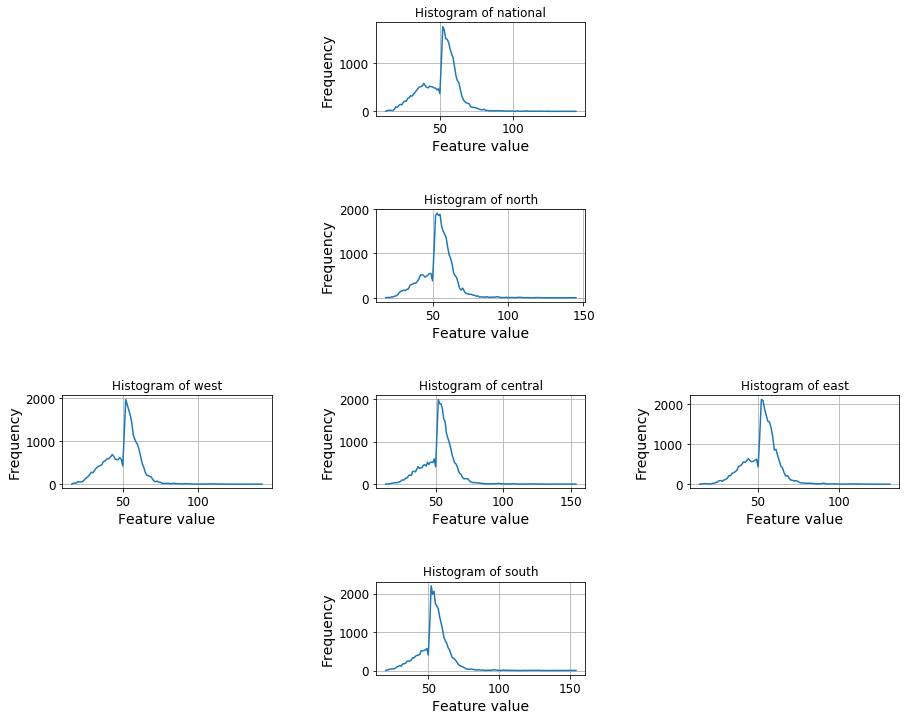

In [10]:
names = data.keys().values.tolist()
fig_position = {'national': 2, 'south': 11, 'north': 5, 'east': 9, 'central': 8, 'west': 7}
fig = plt.figure(figsize=(3*5, 4*3))
fig.subplots_adjust(hspace = 1, wspace=.5)
for i_feature in list(range(6)):
    var = data[names[i_feature]].to_numpy()
    not_nan = ~np.isnan(var)
    var = var[not_nan]
    var = var.astype('int64')
    bin_centers = np.array(range(var.min(), var.max() + 1))
    bin_edges = edge_from_center(bin_centers)
    hist = np.histogram(var, bin_edges)[0]
    plt.subplot(4, 3, fig_position[names[i_feature]])
    plot_histogram(hist, bin_centers, title='Histogram of ' + names[i_feature])

### Histogram of diff_hour  
Records are not evenly distributed over time. The **diff_hour** histogram confirms this claim.

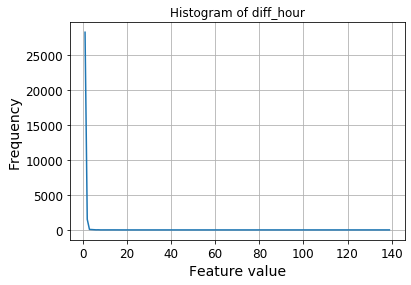

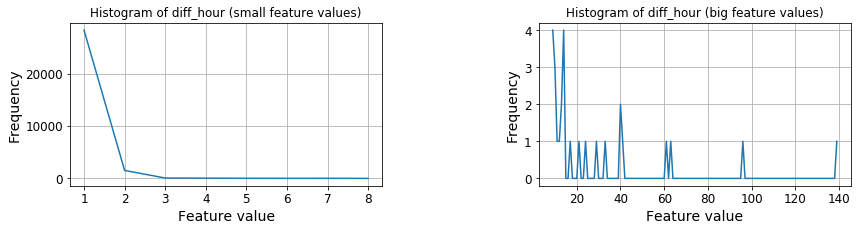

In [11]:
for i_feature in [15]:
    var = data[names[i_feature]].to_numpy()
    not_nan = ~np.isnan(var)
    var = var[not_nan]
    var = var.astype('int64')
    bin_centers = np.array(range(var.min(), var.max() + 1))
    bin_edges = edge_from_center(bin_centers)
    hist = np.histogram(var, bin_edges)[0]
    plt.figure()
    plot_histogram(hist, bin_centers, title='Histogram of ' + names[i_feature])
    fig = plt.figure(figsize=(2*7, 1*3))
    fig.subplots_adjust(hspace = 1, wspace=.5)
    plt.subplot(1,2,1)
    plot_histogram(hist[:8], bin_centers[:8], title='Histogram of ' + names[i_feature] + ' (small feature values)')
    plt.subplot(1,2,2)
    plot_histogram(hist[8:], bin_centers[8:], title='Histogram of ' + names[i_feature] + ' (big feature values)')

Histograms show that the time interval between a record and the previous one is **not** equal. For example 1 record of dataset is **139** hours after the previous one and 2 records are **40** hours after their previous.  

### Sampling the Dataset  
The dataset must be changed so that all records are evenly distributed over time, otherwise the predictor will be confused.  
On the other hand, the number of samples is too large and changes in short time is small.  
Therefore, the data can be sampled so that each 8-hour section of time has only one sample in the new data set. The average values for each 8-hour section of time are placed in the new data set.

In [12]:
# Add a column shows time section: remove origin of time and divide it to 8 hours
time_section_length = 8
origin_datetime = data['datetime'][1]
data['time_section'] = np.floor((data['datetime'] - origin_datetime.to_numpy()) /
                             (time_section_length * np.timedelta64(1, 'h'))).astype('int32')

In [13]:
# New dataset: each row represents an 8 hour time section

time_section_indices = np.arange(start=data['time_section'].min(), stop=data['time_section'].max() + 1)

data_np_time_section = np.empty((time_section_indices.shape[0], 6)).astype('float64')
data_np_time_section[:] = np.NaN  # Initialize matrix with NaN

data_psi = data[names[:6]].to_numpy()  # Just PSI values

# Fill the values with the average of values in each time section, It shows a warning for mean of empty slices
for i in range(time_section_indices.shape[0]):
    data_np_time_section[i, :] = np.mean(data_psi[data['time_section'] == time_section_indices[i], :], axis=0)

# Convert to Dataframe
data_pd_time_section = pd.DataFrame(data_np_time_section, columns=names[:6], index=time_section_indices)

# Fill NaN values with linear interpolation
data_pd_time_section.interpolate(inplace=True)

# Add datetime to New dataset
data_pd_time_section['datetime'] = \
    data_pd_time_section.index.to_series() * (time_section_length * np.timedelta64(1, 'h')) + origin_datetime

# data.to_csv('expanded_data.csv', index=False)
# data_pd_time_section.to_csv('data_time_section.csv')

c:\program files\python36\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\program files\python36\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [14]:
data_pd_time_section.head()

,national,south,north,east,central,west,datetime
0,59.142857,57.571429,54.857143,59.142857,56.571429,56.000000,2016-02-08 23:00:00
1,61.750000,58.250000,57.500000,61.750000,57.750000,57.500000,2016-02-09 07:00:00
2,63.125000,59.375000,58.750000,63.125000,59.000000,60.000000,2016-02-09 15:00:00
3,61.857143,57.285714,56.285714,61.857143,58.000000,58.285714,2016-02-09 23:00:00
4,59.375000,54.500000,53.500000,59.375000,55.250000,54.875000,2016-02-10 07:00:00


In [15]:
# Check for NaN values
data_pd_time_section.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4100 entries, 0 to 4099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   national  4100 non-null   float64       
 1   south     4100 non-null   float64       
 2   north     4100 non-null   float64       
 3   east      4100 non-null   float64       
 4   central   4100 non-null   float64       
 5   west      4100 non-null   float64       
 6   datetime  4100 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 256.2 KB


## 2- Create Train and Test Datasets  
Suppose the predictor gets data of **5 days** and predict the PSI of future 8 hours. So in each element of the training sequence, X_train and y_train contain 5\*3 and 1 values respectively.  
**This predictor only uses 'national' values.** Other values can also be used.

In [16]:
X_length = 5*3  # 5 days
X_y = np.zeros((data_pd_time_section.shape[0] - X_length, X_length + 1))
for i in range(X_y.shape[0]):
    X_y[i, :] = data_pd_time_section['national'].to_numpy()[i:i + X_length + 1]

For a prediction task, first 80% old data is used for train set and the new 20% is used for test set.

In [17]:
# Split train and test sets
test_ratio = 0.2
# indices = np.random.permutation(X_y.shape[0])
indices = np.arange(start=0, stop=X_y.shape[0])
test_set_size = int(X_y.shape[0] * test_ratio)
train_indices = np.sort(indices[:-test_set_size])
test_indices = np.sort(indices[-test_set_size:])

train_data = X_y[train_indices, :]
test_data = X_y[test_indices, :]

print(train_data.shape[0], "train +", test_data.shape[0], "test")

# np.save('./data/train_data', train_data)
# np.save('./data/test_data', test_data)

3268 train + 817 test


## 3- Train Model

In [18]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import time

y_train = train_data[:, -1]
X_train = train_data[:, :-1]

### Scale data with MinMax Scaler

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data.reshape(-1, 1))  # All training data is used to set Min and Max Parameters
X_train_normalized = scaler.transform(X_train)
y_train_normalized = scaler.transform(y_train.reshape(-1, 1))

In [20]:
# Convert numpy arrays to torch tensors
X_train_torch = torch.FloatTensor(X_train_normalized).to(device)
y_train_torch = torch.FloatTensor(y_train_normalized).to(device)

### Splitting Validation Set  
The validation set will be used to prevent overfitting the training model by **Early Stopping** method.

In [21]:
np.random.seed(42)

val_ratio = 0.1
indices = np.random.permutation(X_train_torch.shape[0])
val_set_size = int(X_train_torch.shape[0] * val_ratio)
train_indices = np.sort(indices[:-val_set_size])
val_indices = np.sort(indices[-val_set_size:])

X_val_torch = X_train_torch[val_indices, :].clone()
y_val_torch = y_train_torch[val_indices, :].clone()
X_train_torch = X_train_torch[train_indices, :].clone()
y_train_torch = y_train_torch[train_indices, :].clone()

### Make training sequence

In [22]:
train_inout_seq = []
for i_train in range(X_train_torch.shape[0]):
    train_inout_seq.append((X_train_torch[i_train, :], y_train_torch[i_train]))
print(train_inout_seq[:5])

[(tensor([-0.2772, -0.2355, -0.2136, -0.2338, -0.2735, -0.3174, -0.3867, -0.5729,
        -0.7525, -0.6604, -0.5924, -0.4870, -0.4163, -0.4391, -0.5130],
       device='cuda:0'), tensor([-0.5486], device='cuda:0')), (tensor([-0.2136, -0.2338, -0.2735, -0.3174, -0.3867, -0.5729, -0.7525, -0.6604,
        -0.5924, -0.4870, -0.4163, -0.4391, -0.5130, -0.5486, -0.5289],
       device='cuda:0'), tensor([-0.5210], device='cuda:0')), (tensor([-0.2338, -0.2735, -0.3174, -0.3867, -0.5729, -0.7525, -0.6604, -0.5924,
        -0.4870, -0.4163, -0.4391, -0.5130, -0.5486, -0.5289, -0.5210],
       device='cuda:0'), tensor([-0.4232], device='cuda:0')), (tensor([-0.2735, -0.3174, -0.3867, -0.5729, -0.7525, -0.6604, -0.5924, -0.4870,
        -0.4163, -0.4391, -0.5130, -0.5486, -0.5289, -0.5210, -0.4232],
       device='cuda:0'), tensor([-0.4052], device='cuda:0')), (tensor([-0.3174, -0.3867, -0.5729, -0.7525, -0.6604, -0.5924, -0.4870, -0.4163,
        -0.4391, -0.5130, -0.5486, -0.5289, -0.5210, -0.42

### Define and Initialize Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [24]:
model = LSTM()
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


### Train Model for 150 epochs  
The training procedure will be stopped if **Early Stopping** condition happens.  
When loss on validiation set starts increasing, the model is going to be overfitted on training data and loose  loose generalization ability.  
Therefore, the training stops when average loss on validation set in 5 last epochs is less than the current validation loss.

In [25]:
epochs = 150
y_pred_val_torch = torch.zeros_like(y_val_torch)  # predictions of validation data
epoch_loss = np.zeros(epochs)  # loss of training for each epoch
epoch_val_loss = np.zeros(epochs)  # loss of validation for each epoch
for i_epoch in range(epochs):
    start_time = time.time()
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        # Zero State for each training step
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        epoch_loss[i_epoch] += single_loss  # Accumulating loss of each step for this epoch
    epoch_loss[i_epoch] = epoch_loss[i_epoch] / len(train_inout_seq)  # epoch loss is the average of each etep loss
    # Validation
    for i_val in range(X_val_torch.shape[0]):
        with torch.no_grad():  # forward mode only
            # Zero State for each prediction
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred_val_torch[i_val, :] = model(X_val_torch[i_val, :]).item()  # Prediction
    epoch_val_loss[i_epoch] = loss_function(y_pred_val_torch, y_val_torch)  # epoch loss of validation
    
    print(f'epoch: {i_epoch:3} Loss: {epoch_loss[i_epoch].item():10.8f}'
          f' Validation loss: {epoch_val_loss[i_epoch].item():10.8f}  Elapsed time: {(time.time() - start_time):4.2f}')
    # Early Stopping 
    if i_epoch < 5:
        continue
    if np.mean(epoch_val_loss[i_epoch-5:i_epoch]) < epoch_val_loss[i_epoch]:
        print('Early Stopping at Epoch ', i_epoch)
        break

epoch:   0 Loss: 0.01128851 Validation loss: 0.01475724  Elapsed time: 11.46
epoch:   1 Loss: 0.00431829 Validation loss: 0.00922046  Elapsed time: 11.46
epoch:   2 Loss: 0.00371159 Validation loss: 0.00889940  Elapsed time: 11.30
epoch:   3 Loss: 0.00355930 Validation loss: 0.00810685  Elapsed time: 11.30
epoch:   4 Loss: 0.00347056 Validation loss: 0.00749615  Elapsed time: 11.29
epoch:   5 Loss: 0.00340349 Validation loss: 0.00715775  Elapsed time: 11.29
epoch:   6 Loss: 0.00336081 Validation loss: 0.00698209  Elapsed time: 11.27
epoch:   7 Loss: 0.00332944 Validation loss: 0.00686208  Elapsed time: 11.31
epoch:   8 Loss: 0.00330229 Validation loss: 0.00675395  Elapsed time: 11.37
epoch:   9 Loss: 0.00327692 Validation loss: 0.00662467  Elapsed time: 11.37
epoch:  10 Loss: 0.00325146 Validation loss: 0.00646198  Elapsed time: 11.32
epoch:  11 Loss: 0.00322501 Validation loss: 0.00627862  Elapsed time: 11.43
epoch:  12 Loss: 0.00319792 Validation loss: 0.00609549  Elapsed time: 11.55

### ُSave Model

In [26]:
np.save('./data/loss', epoch_loss)
np.save('./data/val_loss', epoch_val_loss)
torch.save(model, './data/best_trained_model')  # It shows a warning for the defenition LSTM Class

c:\program files\python36\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Training and Validation Loss

Text(0, 0.5, 'MSE Loss')

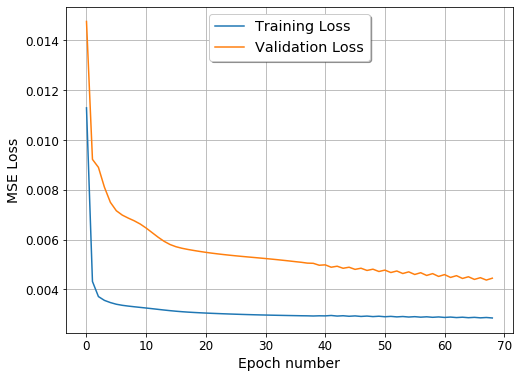

In [27]:
stopped_epoch = np.argwhere(epoch_loss == 0)[0, 0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epoch_loss[:stopped_epoch], label='Training Loss')
ax.plot(epoch_val_loss[:stopped_epoch], label='Validation Loss')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')

## 4- Prediction

In [28]:
# Data and Label
y_test = test_data[:, -1]
X_test = test_data[:, :-1]
# Normalize test set with Scaler fitted with train data
X_test_normalized = scaler.transform(X_test)
y_test_normalized = scaler.transform(y_test.reshape(-1, 1))
# Convert numpy arrays to torch tensors
X_test_torch = torch.FloatTensor(X_test_normalized).to(device)
y_test_torch = torch.FloatTensor(y_test_normalized).to(device)
# Predictions
y_pred_normalized = np.zeros_like(y_test_normalized)

### Make Predictions on the Test set
In this project former predictions are not used for the later ones and all predictions use real values as input.  
The other method is also applicable and has less accuracy due to error propagation.

In [29]:
model.eval()
for i in range(X_test_torch.shape[0]):
    with torch.no_grad():  # forward mode only
        # Zero State for each prediction
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred_normalized[i, :] = model(X_test_torch[i, :]).item()  # Prediction
# Inverse of Normalization
y_pred = np.squeeze(scaler.inverse_transform(y_pred_normalized.reshape(-1, 1)))

### Error of Predictions

In [30]:
err = y_test - y_pred
# Root Mean Square Error
rmse = np.sqrt(np.mean(np.power(err, 2)))
rmse

4.521444512327794

### Plot the results

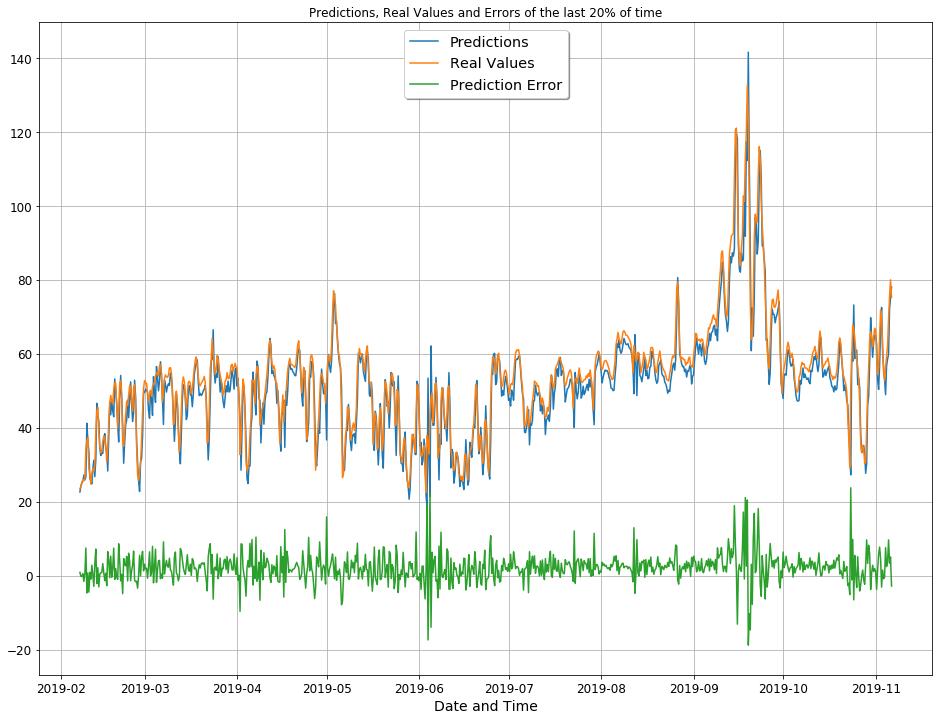

In [31]:
fig, ax = plt.subplots(figsize=(16, 12))
datetime = data_pd_time_section['datetime'][test_indices + X_length]
ax.plot(datetime, y_pred, label='Predictions')
ax.plot(datetime, y_test, label='Real Values')
ax.plot(datetime, err, label='Prediction Error')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.xlabel('Date and Time')
plt.title('Predictions, Real Values and Errors of the last 20% of time')
ax.grid(True)

### Make Prediction on one sample

In [32]:
def predict_psi_level(X, model, scaler):
    # Normalize test set with Scaler fitted with train data
    X_normalized = scaler.transform(X.reshape(-1, 1))
    # Convert numpy arrays to torch tensors
    X_torch = torch.FloatTensor(X_normalized).to(device)
    model.eval()
    with torch.no_grad():  # forward mode only
        # Zero State for each prediction
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        prediction_normalized = np.array(model(X_torch).item())  # Prediction
    # Inverse of Normalization
    prediction = np.squeeze(scaler.inverse_transform(prediction_normalized.reshape(-1, 1)))

    psi_bands = np.array([0., 56., 150., 250])
    psi_levels = ['Normal', 'Elevated', 'High', 'Very high']
    return psi_levels[np.argwhere(prediction >= psi_bands)[-1][0]]

In [33]:
i_test = 10
X = test_data[i_test, :-1]

PSI_level = predict_psi_level(X, model, scaler)
PSI_level

'Normal'

## Future work  
There some suggestions to make a better project and better predictions.
1. Model training can be done with another code so that the result does not change every time we run this file.
2. Predictions on test set can be done using predicted values.
3. Input feature can be all of the features of dataset, not just the 'national' PSI.
4. This data is cyclostationary and statistical properties vary cyclically with time. Probably these statistical properties has a period of one week or one year. Therefore, we can add 2 new parameters that indicate the time of the week (0 to 6 days or 0 to 7\*8-1) and the time of the year (0 to 354 days or 0 to 365\*8-1) to acheive better predictions.